In [114]:
import pandas as pd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import json
import math

In [115]:
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
s=requests.get(url).content
confirmed = pd.read_csv(BytesIO(s))

In [116]:
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
s=requests.get(url).content
dead = pd.read_csv(BytesIO(s))

In [117]:
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
s=requests.get(url).content
recovered = pd.read_csv(BytesIO(s))

In [118]:
OFFSET = 100

In [119]:
def by_country(df):
    return df.drop(columns=['Province/State', 'Lat', 'Long']).groupby('Country/Region').sum().sort_values([df.columns.tolist()[-1]], ascending=False)

confirmed_country = by_country(confirmed)
dead_country = by_country(dead)
recovered_country = by_country(recovered)

In [120]:
# Fix 2020-03-12, see https://github.com/CSSEGISandData/COVID-19/issues/599
# Italy: 15113 confirmed cases, 1016 death and 1258 recovered
confirmed_country['3/12/20']['Italy'] = 15113
dead_country['3/12/20']['Italy'] = 1016

recovered_country['4/6/20']['Germany'] = 32390

In [121]:
infections_country = confirmed_country.sub(confirmed_country.shift(axis='columns', periods=1))
recoveries_country = recovered_country.sub(recovered_country.shift(axis='columns', periods=1))
deaths_country = dead_country.sub(dead_country.shift(axis='columns', periods=1))
net_new_infectious_country = infections_country.sub(recoveries_country).sub(deaths_country).reindex(index=infections_country.index)

In [122]:
#confirmed_country.head(20)

In [123]:
#confirmed_country.head(10)

In [124]:
#active_country = confirmed_country.sub(confirmed_country.shift(axis='columns', periods=14))
active_country = confirmed_country.sub(dead_country).sub(recovered_country).reindex(index=confirmed_country.index)
realtive_change_active_country = active_country.divide(active_country.shift(axis='columns', periods=1))-1

In [125]:
country = 'Germany'

In [126]:
pd.DataFrame(infections_country.loc[country]).tail(10)

,Germany
5/10/20,555.0
5/11/20,697.0
5/12/20,595.0
5/13/20,927.0
5/14/20,380.0
5/15/20,755.0
5/16/20,519.0
5/17/20,617.0
5/18/20,182.0
5/19/20,1227.0


In [127]:
pd.DataFrame(confirmed_country.loc[country]).tail(10)

,Germany
5/10/20,171879
5/11/20,172576
5/12/20,173171
5/13/20,174098
5/14/20,174478
5/15/20,175233
5/16/20,175752
5/17/20,176369
5/18/20,176551
5/19/20,177778


In [128]:
pd.DataFrame(dead_country.loc[country]).tail(10)

,Germany
5/10/20,7569
5/11/20,7661
5/12/20,7738
5/13/20,7861
5/14/20,7884
5/15/20,7897
5/16/20,7938
5/17/20,7962
5/18/20,8003
5/19/20,8081


In [129]:
pd.DataFrame(recovered_country.loc[country]).tail(10)

,Germany
5/10/20,144400
5/11/20,145617
5/12/20,147200
5/13/20,148700
5/14/20,150300
5/15/20,151597
5/16/20,152600
5/17/20,154011
5/18/20,155041
5/19/20,155681


In [130]:
pd.DataFrame(active_country.loc[country]).tail(10)

,Germany
5/10/20,19910
5/11/20,19298
5/12/20,18233
5/13/20,17537
5/14/20,16294
5/15/20,15739
5/16/20,15214
5/17/20,14396
5/18/20,13507
5/19/20,14016


In [131]:
pd.DataFrame(deaths_country.loc[country]).tail(10)

,Germany
5/10/20,20.0
5/11/20,92.0
5/12/20,77.0
5/13/20,123.0
5/14/20,23.0
5/15/20,13.0
5/16/20,41.0
5/17/20,24.0
5/18/20,41.0
5/19/20,78.0


In [132]:
pd.DataFrame(recoveries_country.loc[country]).tail(10)

,Germany
5/10/20,1100.0
5/11/20,1217.0
5/12/20,1583.0
5/13/20,1500.0
5/14/20,1600.0
5/15/20,1297.0
5/16/20,1003.0
5/17/20,1411.0
5/18/20,1030.0
5/19/20,640.0


In [133]:
all_styles=markers = ["o-", "v-", "^-", "P-", "X-", "s-", "<-", ">-", "8-", "p-", "*-", "h-", "H-", "+-", "x-", "D-", "d-", "|-", "_-", ".-", "1-", "2-", "3-", "4-"]

In [134]:
def relative(df, offset=OFFSET):
    rows = []
    for country, row in df.iterrows():
        day_n = 0
        data = dict()
        data['country'] = country
        for date, value in row.iteritems():
            if confirmed_country.loc[country][date] >= offset or day_n > 0:
                data[day_n] = value
                day_n += 1
        rows.append(data)
    return pd.DataFrame.from_records(rows, index='country').dropna(how='all')

In [135]:
def plottable(df, countries=['China', 'Others', 'Cruise Ship'], mode='exclude'):
    filtered = df[df.index.isin(countries)] if mode == 'include' else df[~df.index.isin(countries)]
    plot_data = filtered.head(8).T.dropna(how='all')
    return plot_data

In [136]:
def plot_linear(plot_data, what='Confirmed', offset=OFFSET):
    fig, ax = plt.subplots(figsize=(10,6), dpi=150)
    plot_data.plot.line(ax=ax) # style=all_styles, ms=5
    plt.legend(loc='upper left')
    ax.set(xlabel=('Day N after the first %d Confirmed Cases' % offset), ylabel=('%s Cases' % what))
    return ax

In [137]:
def plot_log(plot_data, what='Confirmed', growth_rate=0.30, offset=OFFSET, ymin=None):
    fig, ax = plt.subplots(figsize=(10,5.5), dpi=150)
    plot_data.plot.line(ax=ax)
    plt.legend(loc='upper left')
    ax.set(xlabel=('Day N after the first %d Confirmed Cases' % offset), ylabel=('%s Cases' % what))
    ax.set_yscale('log')
    ax.set_ylim(bottom=(ymin if ymin is not None else offset * 0.8))
    x = np.arange(0, len(plot_data), 1)
    y = offset*np.exp(x*growth_rate)

    plt.plot(x, y, 'k-')
    return ax

In [138]:
#plot_linear(plottable(relative(confirmed_country)))

In [139]:
#plot_linear(plottable(relative(active_country)), what='Active')

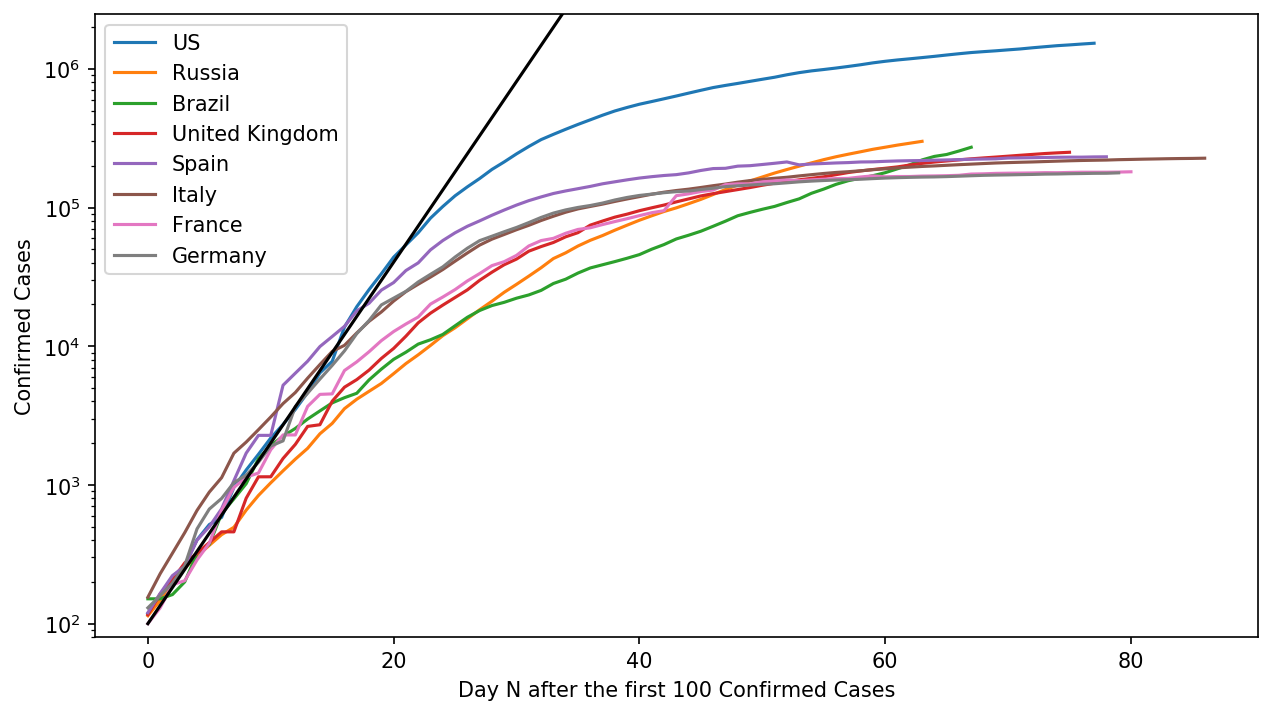

In [140]:
plot_log(plottable(relative(confirmed_country)))

In [141]:
#plot_log(plottable(relative(active_country)), what='Active')

In [142]:
#plot_linear(plottable(relative(active_country), countries=['Other']), what='Active')

In [143]:
#plot_log(plottable(relative(active_country), countries=['Other']), what='Active')

In [144]:
#plot_data = plottable(active_country, countries=['Other']).iloc[10:]
#what = 'Active'
#plot_data = plot_data.reset_index().rename(columns={"index":"day"})
#fig, ax = plt.subplots(figsize=(10,6), dpi=150)
#plot_data.plot.line(ax=ax, style='-', rot=45, xticks=plot_data.index)
#plt.legend(loc='upper left')
#offset = OFFSET
#ax.set(ylabel=('%s Cases' % what))
#ax.set_xticklabels(plot_data["day"], fontsize='x-small', horizontalalignment='right');

In [145]:
#plot_data = plottable(dead_country, countries=['Other'])
#what = 'Deaths'
#plot_data = plot_data.reset_index().rename(columns={"index":"day"})
#fig, ax = plt.subplots(figsize=(10,6), dpi=150)
#plot_data.plot.line(ax=ax, style='.-', rot=45, xticks=plot_data.index)
#plt.legend(loc='upper left')
#ax.set(ylabel=('%s' % what))
#ax.set_xticklabels(plot_data["day"], fontsize='x-small', horizontalalignment='right');

In [146]:
#plot_log(plottable(relative(confirmed_country), countries=['China', 'Others', 'Cruise Ship', 'Iran', 'Korea, South']), growth_rate=0.30, offset=100)

In [147]:
#plot_log(plottable(relative(active_country), countries=['China', 'Others', 'Cruise Ship', 'Iran', 'Korea, South', 'Italy']), growth_rate=0.30, offset=100, what='Active')

In [148]:
#plot_log(plottable(relative(confirmed_country), countries=['China', 'Others', 'Cruise Ship', 'Iran', 'Korea, South']), growth_rate=0.30, offset=100)

In [149]:
#plot_log(plottable(relative(dead_country)), what='Death', ymin=1, offset=1)

In [150]:
#plot_log(plottable(relative(dead_country), countries=['Czechia', 'Germany', 'Italy', 'Norway'], mode='include'), what='Death', ymin=1, offset=1)

In [151]:
#plot_linear(plottable(relative(confirmed_country, offset=30), countries=['Czechia', 'Germany', 'Italy'], mode='include').head(10), offset=30)
#plot_log(plottable(relative(active_country, offset=30), countries=['Czechia', 'Germany', 'Italy', 'Switzerland', 'Norway', 'Sweden', 'Austria'], mode='include'), growth_rate=0.30, offset=30, what='Active')

In [152]:
#plot_linear(plottable(relative(dead_country), countries=['Other']).iloc[:25], what='Death')

In [153]:
def index_for_day(data, day):
  return data[data['day'] == day].index.values[0]

In [154]:
def fit_range(plt, plot_data, column, start_date, end_date, fmt='-', **kwargs):
  fit_data = plot_data.reset_index().rename(columns={"index":"day"})
  index_start = index_for_day(fit_data, pd.to_datetime(start_date))
  index_end = index_for_day(fit_data, pd.to_datetime(end_date))
  fit_data = fit_data.iloc[index_start:index_end+1]
  [growth_rate, A] = np.polyfit(fit_data[column].index.values, np.log(fit_data[column].values), 1)
  x = np.arange(index_start-2, index_end+3, 1)
  y = np.exp(A)*np.exp(x*growth_rate)
  start_datetime = pd.to_datetime(start_date)
  x = [start_datetime + mdates.num2timedelta(int(day)-int(index_start)) for day in x]
  plt.plot_date(x, y, fmt, **kwargs)
  return growth_rate

In [155]:
def plot_dates(df=None, countries=None, start_date=None, what='Confirmed Cases', ylim_bottom=10, yscale='log'):
  plot_data = plottable(df, countries=countries, mode='include').loc[start_date:]
  plot_data.index = pd.to_datetime(plot_data.index)
  #plot_data = plot_data.reset_index().rename(columns={"index":"day"})
  #plot_data['day'] = pd.to_datetime(plot_data['day'])
  fig, ax = plt.subplots(figsize=(10,6), dpi=150)
  #plot_data.plot.line(ax=ax, style='-', rot=45, zorder=100)
  for country in countries:
    plt.plot(plot_data.index, plot_data[country], label=country)
  plt.legend(loc='lower right')
  plt.grid()
  
  ax.set(ylabel=(what))

  #ax.set_xticklabels(plot_data["day"], fontsize='x-small', horizontalalignment='right');
  plt.minorticks_off()
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %b %d'))
  plt.xticks(rotation=45, horizontalalignment='right', fontsize='x-small')

  ax.set_yscale(yscale)
  ax.set_ylim(bottom=ylim_bottom)
  return (plot_data, ax)

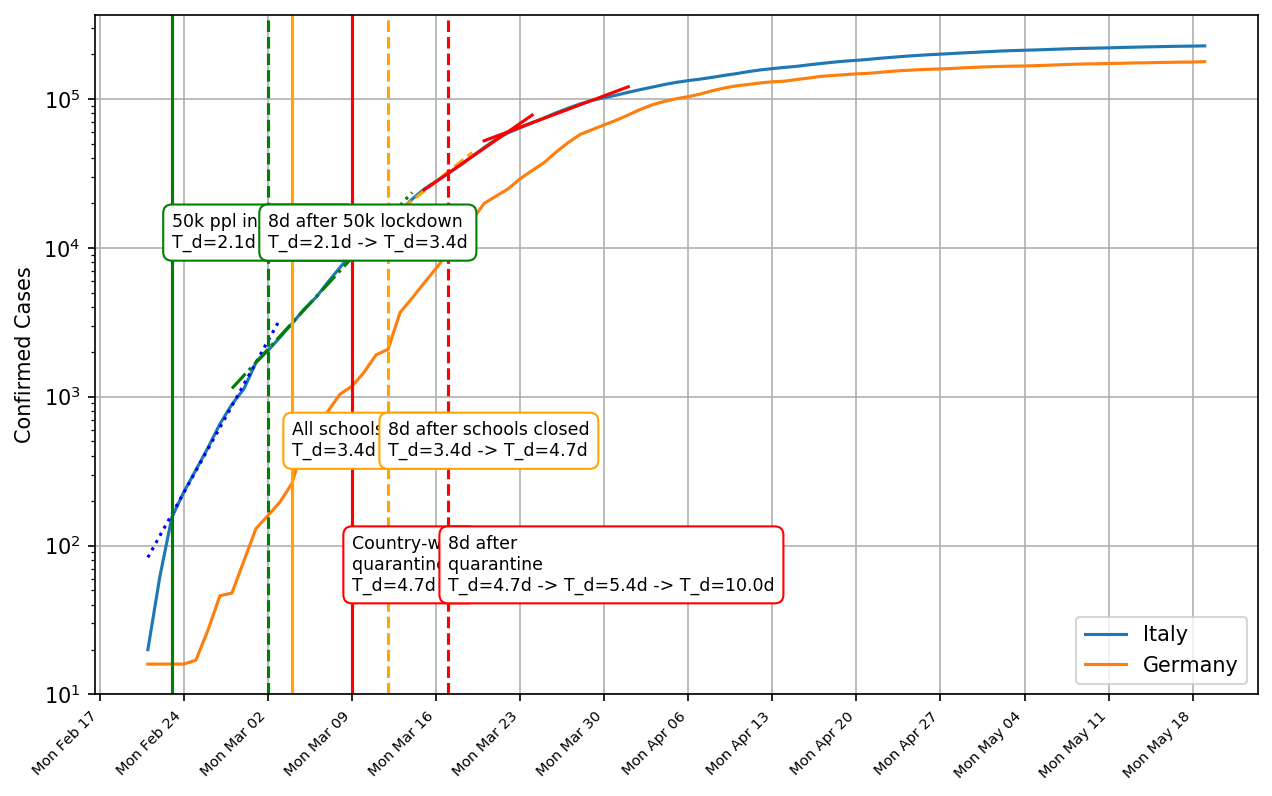

In [156]:
(plot_data, ax) = plot_dates(df=confirmed_country, countries=['Italy', 'Germany'], start_date='2/21/20')

# Feb 23 = 50k ppl in Quarantine
lockdown_rate = fit_range(plt, plot_data, 'Italy', start_date='2/23/20', end_date='3/1/20', fmt=':', color='blue')

# Mar 4 = Schools closed
school_close_rate = fit_range(plt, plot_data, 'Italy', start_date='3/1/20', end_date='3/12/20', fmt='-.', color='green')

# Mar 4 = Schools closed
pre_quarantine_rate = fit_range(plt, plot_data, 'Italy', start_date='3/12/20', end_date='3/17/20', fmt='--', color='orange')

# Mar 4 = Schools closed
quarantine_rate = fit_range(plt, plot_data, 'Italy', start_date='3/17/20', end_date='3/22/20', fmt='-', color='red')

recent_rate = fit_range(plt, plot_data, 'Italy', start_date='3/22/20', end_date='3/30/20', fmt='-', color='red')

index=pd.to_datetime('2/23/20')
ax.axvline(x=index, linestyle='solid', color='green')
ax.text(x=index, y=1*10**4, s='50k ppl in lockdown\nT_d=%.1fd' % (math.log(2)/lockdown_rate), fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(8), linestyle='dashed', color='green')
ax.text(x=index+mdates.num2timedelta(8), y=1*10**4, s='8d after 50k lockdown\nT_d=%.1fd -> T_d=%.1fd' % ((math.log(2)/lockdown_rate), (math.log(2)/school_close_rate)), fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))

index=pd.to_datetime('3/4/20')
ax.axvline(x=index, linestyle='solid', color='orange')
ax.text(x=index, y=4*10**2, s='All schools closed\nT_d=%.1fd' % (math.log(2)/school_close_rate), fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(8), linestyle='dashed', color='orange')
ax.text(x=index+mdates.num2timedelta(8), y=4*10**2, s='8d after schools closed\nT_d=%.1fd -> T_d=%.1fd' % ((math.log(2)/school_close_rate), (math.log(2)/pre_quarantine_rate)), fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))

index=pd.to_datetime('3/9/20')
ax.axvline(x=index, linestyle='solid', color='red')
ax.text(x=index, y=5*10**1, s='Country-wide\nquarantine\nT_d=%.1fd' % (math.log(2)/pre_quarantine_rate), fontsize='small', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(8), linestyle='dashed', color='red')
ax.text(x=index+mdates.num2timedelta(8), y=5*10**1, s='8d after\nquarantine\nT_d=%.1fd -> T_d=%.1fd -> T_d=%.1fd' % ((math.log(2)/pre_quarantine_rate), (math.log(2)/quarantine_rate), (math.log(2)/recent_rate)), fontsize='small', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))
plt.show()

0.040584890119202674

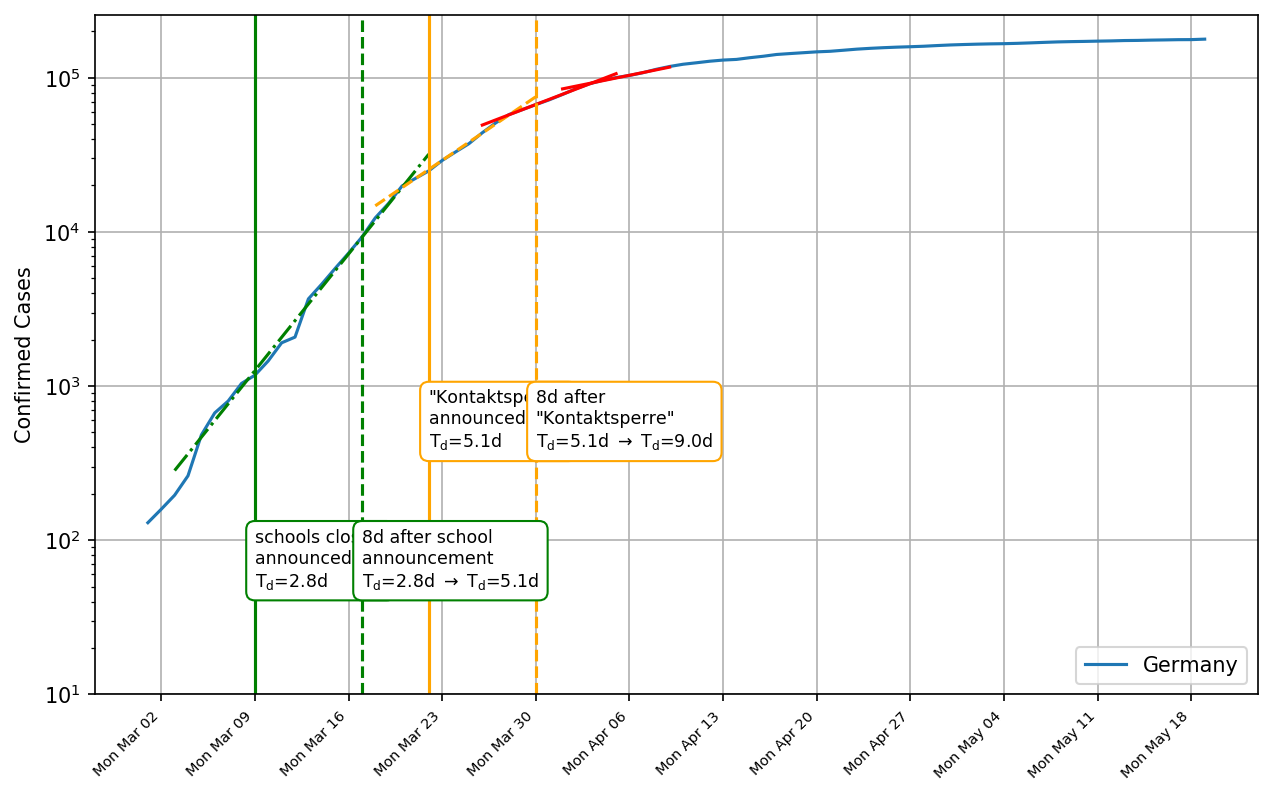

In [157]:
(plot_data, ax) = plot_dates(df=confirmed_country, countries=['Germany'], start_date='3/1/20')

# Mar 13 = Schools closed announced
# Mar 17 = Schools closed enforced
initial_rate = fit_range(plt, plot_data, 'Germany', start_date='3/5/20', end_date='3/20/20', fmt='-.', color='green')

# Mar 4 = Schools closed
school_close_rate = fit_range(plt, plot_data, 'Germany', start_date='3/20/20', end_date='3/28/20', fmt='--', color='orange')

# Mar 22 = "Kontaktsperre"
quarantine_rate = fit_range(plt, plot_data, 'Germany', start_date='3/28/20', end_date='4/3/20', fmt='-', color='red')

index==pd.to_datetime('3/13/20')
ax.axvline(x=index, linestyle='solid', color='green')
ax.text(x=index, y=5*10**1, s='schools closing\nannounced\n$\mathregular{T_d}$=%.1fd' % (math.log(2)/initial_rate), fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(8), linestyle='dashed', color='green')
ax.text(x=index+mdates.num2timedelta(8), y=5*10**1, s='8d after school\nannouncement\n$\mathregular{T_d}$=%.1fd $\\rightarrow$ $\mathregular{T_d}$=%.1fd' % ((math.log(2)/initial_rate), (math.log(2)/school_close_rate)), fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))

index=pd.to_datetime('3/22/20')
ax.axvline(x=index, linestyle='solid', color='orange')
ax.text(x=index, y=4*10**2, s='"Kontaktsperre"\nannounced\n$\mathregular{T_d}$=%.1fd' % (math.log(2)/school_close_rate), fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(8), linestyle='dashed', color='orange')
ax.text(x=index+mdates.num2timedelta(8), y=4*10**2, s='8d after\n"Kontaktsperre"\n$\mathregular{T_d}$=%.1fd $\\rightarrow$ $\mathregular{T_d}$=%.1fd' % ((math.log(2)/school_close_rate), (math.log(2)/quarantine_rate)), fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))

latest_rate = fit_range(plt, plot_data, 'Germany', start_date='4/3/20', end_date='4/7/20', linestyle='solid', color='red')
latest_rate

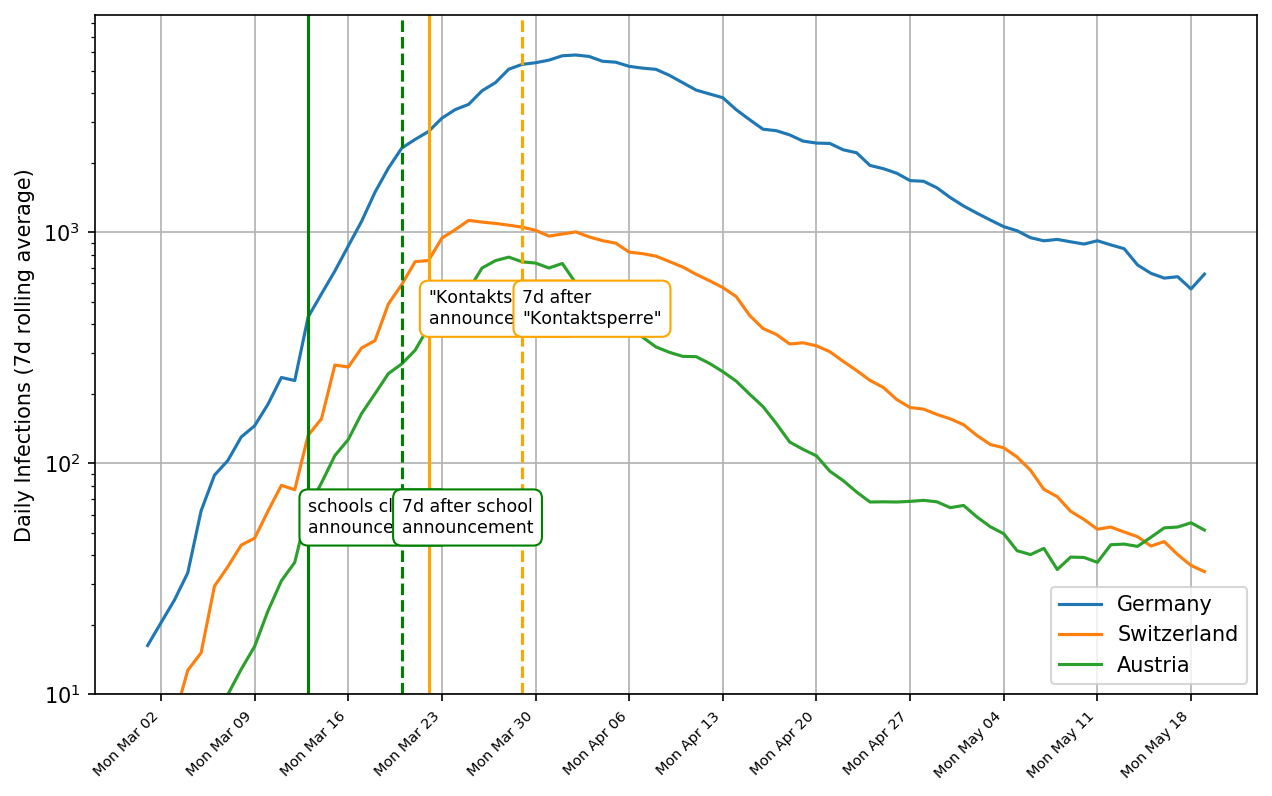

In [158]:
(plot_data, ax) = plot_dates(df=infections_country.rolling(7, axis=1).mean(), countries=['Germany', 'Switzerland', 'Austria'], start_date='3/1/20', what='Daily Infections (7d rolling average)')

index=pd.to_datetime('3/13/20')
ax.axvline(x=index, linestyle='solid', color='green')
ax.text(x=index, y=5*10**1, s='schools closing\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(7), linestyle='dashed', color='green')
ax.text(x=index+mdates.num2timedelta(7), y=5*10**1, s='7d after school\nannouncement', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))

index=pd.to_datetime('3/22/20')
ax.axvline(x=index, linestyle='solid', color='orange')
ax.text(x=index, y=4*10**2, s='"Kontaktsperre"\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(7), linestyle='dashed', color='orange')
ax.text(x=index+mdates.num2timedelta(7), y=4*10**2, s='7d after\n"Kontaktsperre"', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))

plt.show()

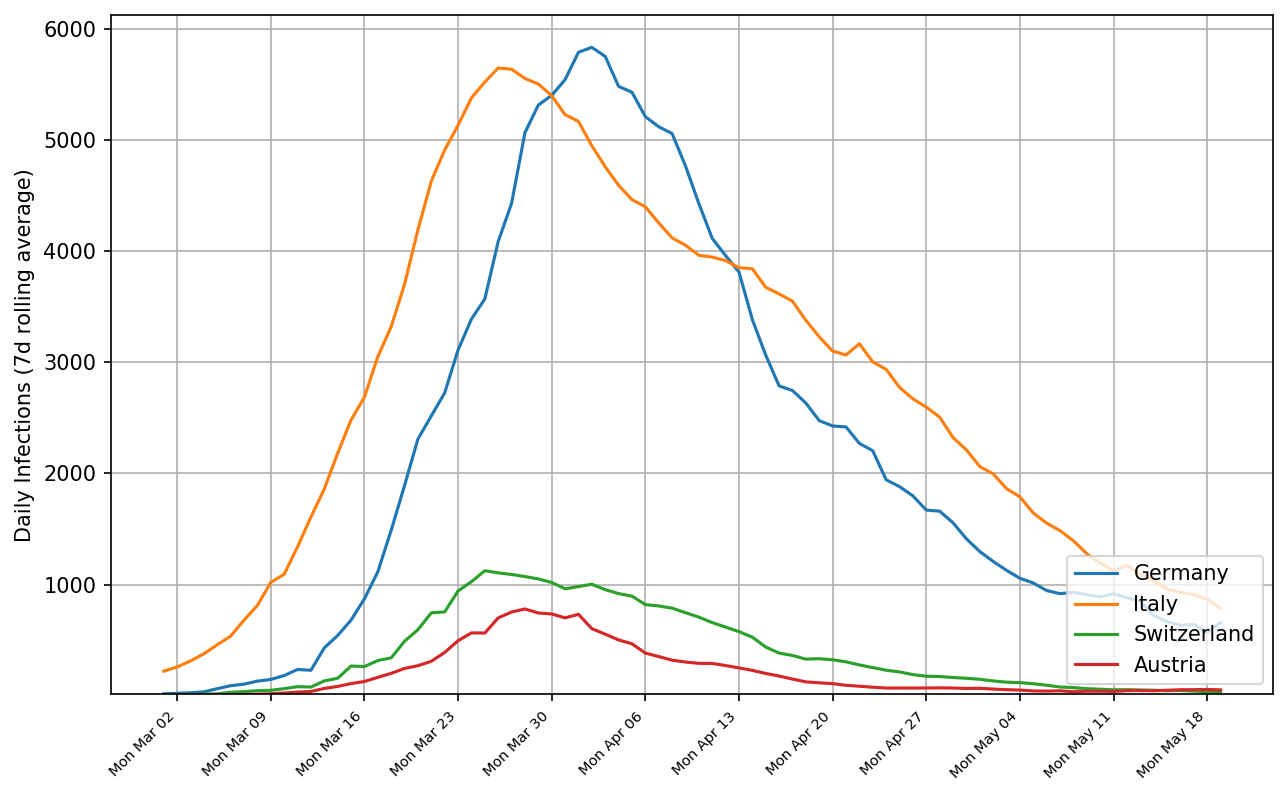

In [159]:
(plot_data, ax) = plot_dates(df=infections_country.rolling(7, axis=1).mean(), countries=['Germany', 'Italy', 'Switzerland', 'Austria'], start_date='3/1/20', what='Daily Infections (7d rolling average)', yscale='linear')

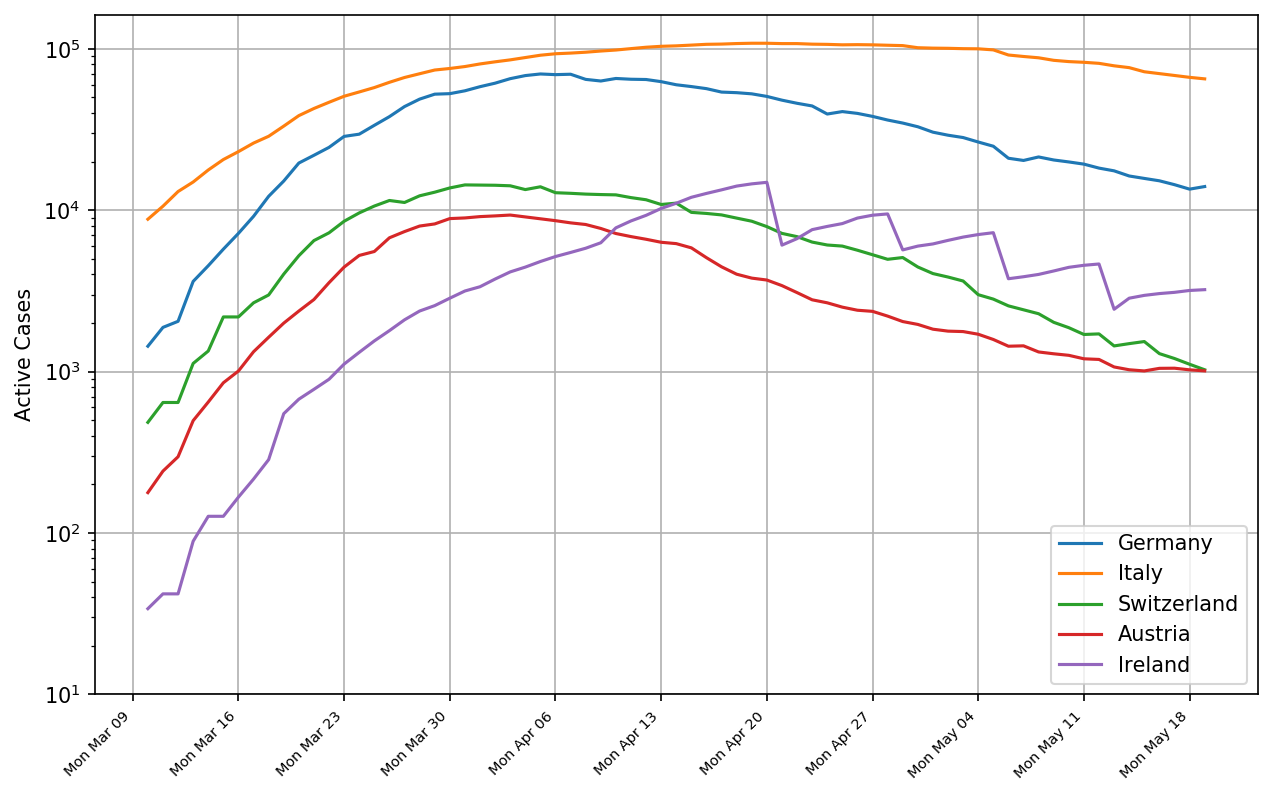

In [160]:
(plot_data, ax) = plot_dates(df=active_country, countries=['Germany', 'Italy', 'Switzerland', 'Austria', 'Ireland'], start_date='3/10/20', what='Active Cases', ylim_bottom=10, yscale='log')

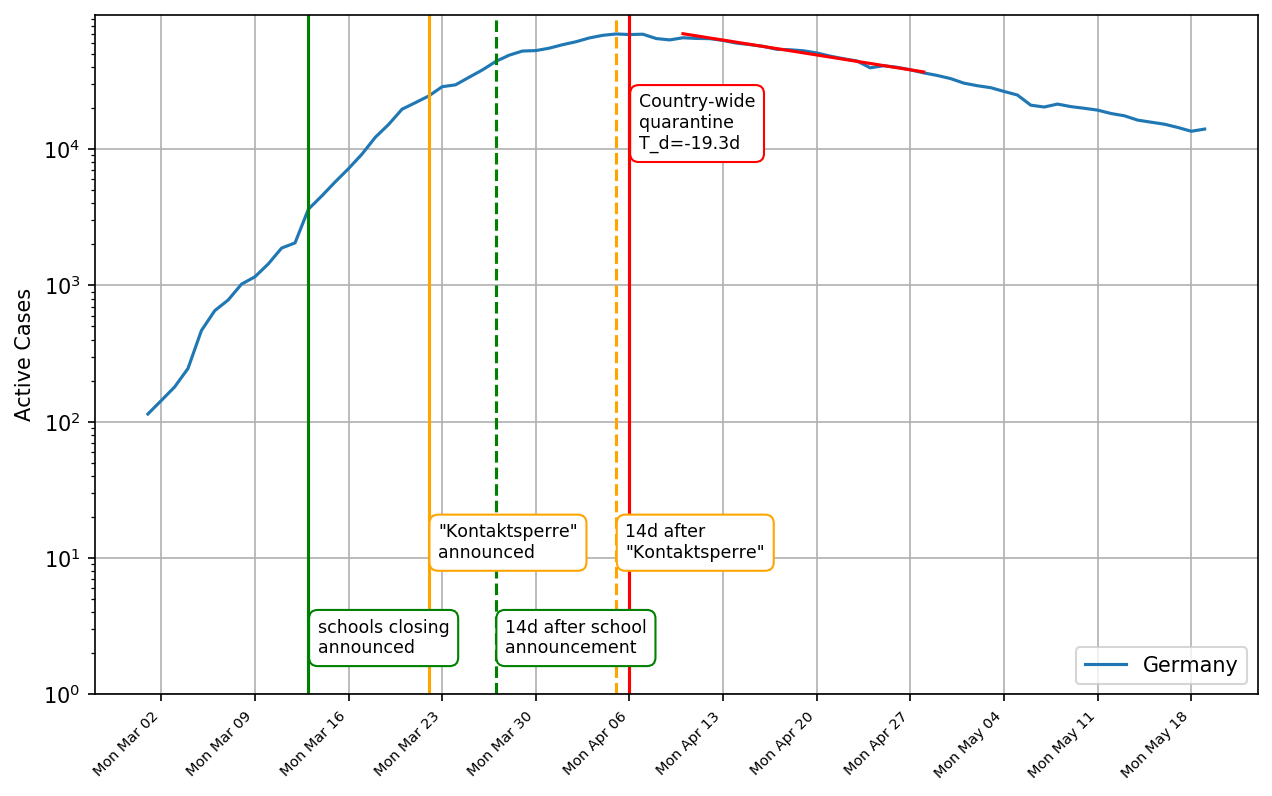

In [161]:
(plot_data, ax) = plot_dates(df=active_country, countries=['Germany'], start_date='3/1/20', what='Active Cases', ylim_bottom=1)

# Apr 6 = "Peak"
post_quarantine_rate = fit_range(plt, plot_data, 'Germany', start_date='4/12/20', end_date='4/26/20', fmt='-', color='red')

index=pd.to_datetime('3/13/20')
ax.axvline(x=index, linestyle='solid', color='green')
ax.text(x=index+mdates.num2timedelta(0.7), y=2*10**0, s='schools closing\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(14), linestyle='dashed', color='green')
ax.text(x=index+mdates.num2timedelta(0.7+14), y=2*10**0, s='14d after school\nannouncement', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))

index=pd.to_datetime('3/22/20')
ax.axvline(x=index, linestyle='solid', color='orange')
ax.text(x=index+mdates.num2timedelta(0.7), y=1*10**1, s='"Kontaktsperre"\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(14), linestyle='dashed', color='orange')
ax.text(x=index+mdates.num2timedelta(0.7+14), y=1*10**1, s='14d after\n"Kontaktsperre"', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))

index=pd.to_datetime('4/6/20')
ax.axvline(x=index, linestyle='solid', color='red')
ax.text(x=index+mdates.num2timedelta(0.7), y=1*10**4, s='Country-wide\nquarantine\nT_d=%.1fd' % (math.log(2)/post_quarantine_rate), fontsize='small', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))
plt.show()

#plt.grid()
plt.show()

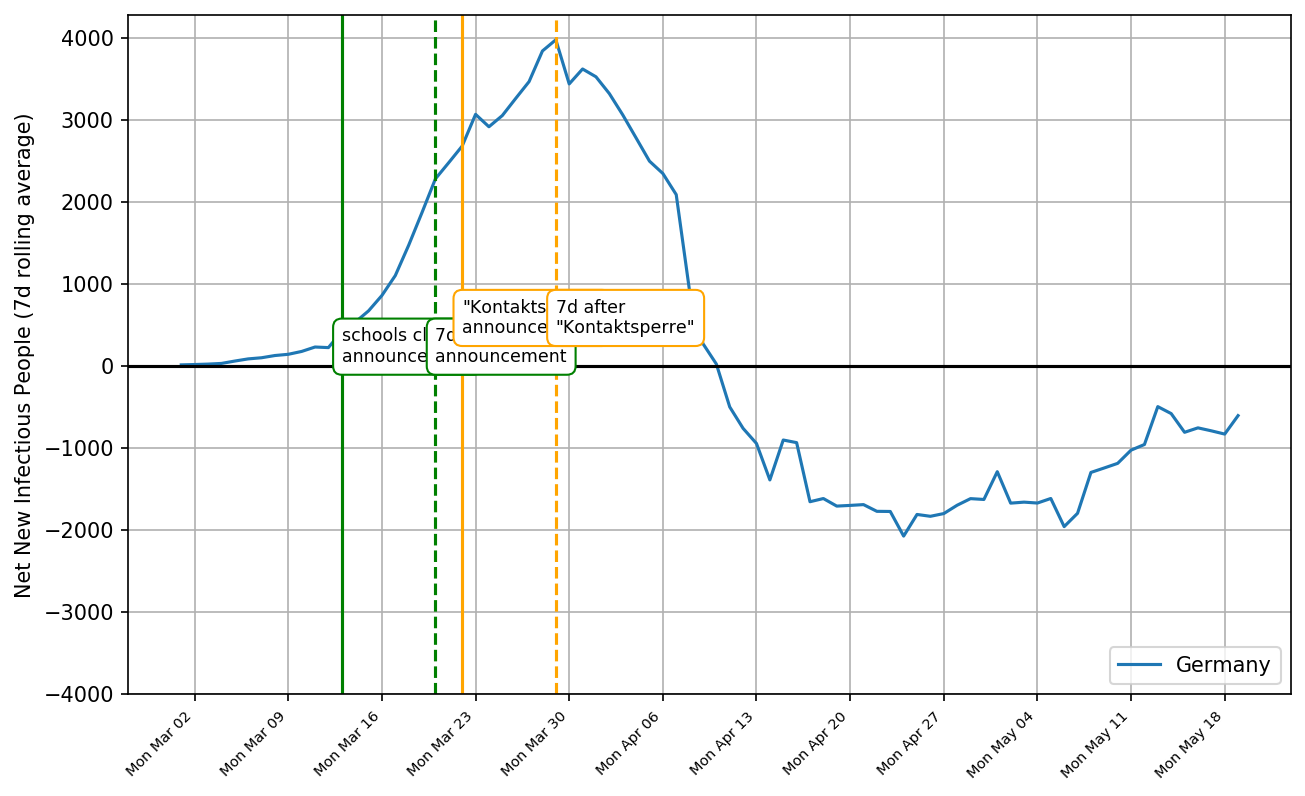

In [162]:
#(plot_data, ax) = plot_dates(df=net_new_infectious_country.rolling(7,
#                                                                   axis=1,
#                                                                   win_type='gaussian',
#                                                                   min_periods=1,
#                                                                   center=True).mean(std=2), countries=['Germany'], start_date='3/1/20', what='Net New Infectious People (7d rolling average)', ylim_bottom=-4000, yscale='linear')

(plot_data, ax) = plot_dates(df=net_new_infectious_country.rolling(7, axis=1).mean(), countries=['Germany'], start_date='3/1/20', what='Net New Infectious People (7d rolling average)', ylim_bottom=-4000, yscale='linear')
plt.axhline(0, color='black')

index=pd.to_datetime('3/13/20')
ax.axvline(x=index, linestyle='solid', color='green')
ax.text(x=index, y=5*10**1, s='schools closing\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(7), linestyle='dashed', color='green')
ax.text(x=index+mdates.num2timedelta(7), y=5*10**1, s='7d after school\nannouncement', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))

index=pd.to_datetime('3/22/20')
ax.axvline(x=index, linestyle='solid', color='orange')
ax.text(x=index, y=4*10**2, s='"Kontaktsperre"\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(7), linestyle='dashed', color='orange')
ax.text(x=index+mdates.num2timedelta(7), y=4*10**2, s='7d after\n"Kontaktsperre"', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))

plt.show()

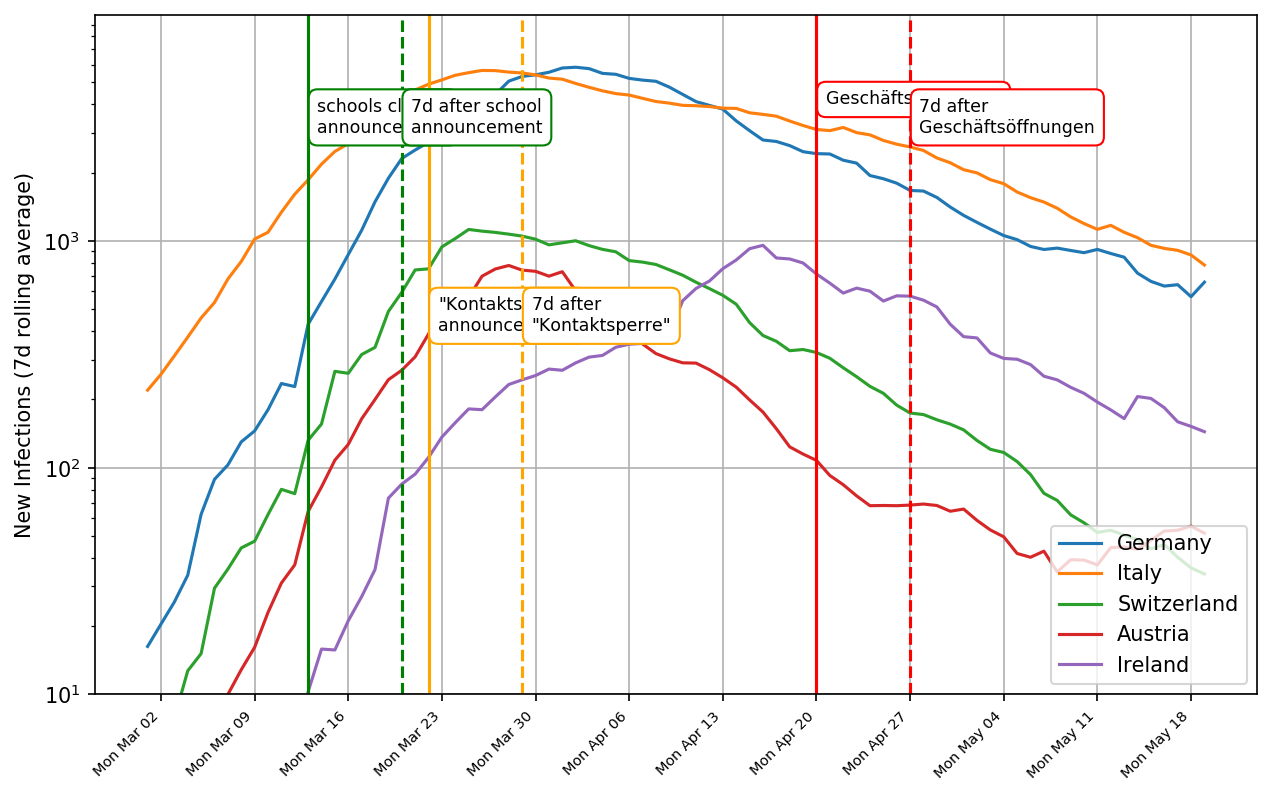

In [163]:
(plot_data, ax) = plot_dates(df=infections_country.rolling(7, axis=1).mean(), countries=['Germany','Italy','Switzerland','Austria','Ireland'], start_date='3/1/20', what='New Infections (7d rolling average)', ylim_bottom=10, yscale='log')

index=pd.to_datetime('3/13/20')
ax.axvline(x=index, linestyle='solid', color='green')
ax.text(x=index+mdates.num2timedelta(0.7), y=3*10**3, s='schools closing\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(7), linestyle='dashed', color='green')
ax.text(x=index+mdates.num2timedelta(0.7+7), y=3*10**3, s='7d after school\nannouncement', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))

index=pd.to_datetime('3/22/20')
ax.axvline(x=index, linestyle='solid', color='orange')
ax.text(x=index+mdates.num2timedelta(0.7), y=4*10**2, s='"Kontaktsperre"\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(7), linestyle='dashed', color='orange')
ax.text(x=index+mdates.num2timedelta(0.7+7), y=4*10**2, s='7d after\n"Kontaktsperre"', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))

index=pd.to_datetime('4/20/20')
ax.axvline(x=index, linestyle='solid', color='red')
ax.text(x=index+mdates.num2timedelta(0.7), y=4*10**3, s='Geschäftsöffnungen', fontsize='small', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(7), linestyle='dashed', color='red')
ax.text(x=index+mdates.num2timedelta(0.7+7), y=3*10**3, s='7d after\nGeschäftsöffnungen', fontsize='small', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

# 4/20/20 Geschäftsöffnungen
# 4/27/20 Mundschutzpflicht

#plt.grid()
plt.show()

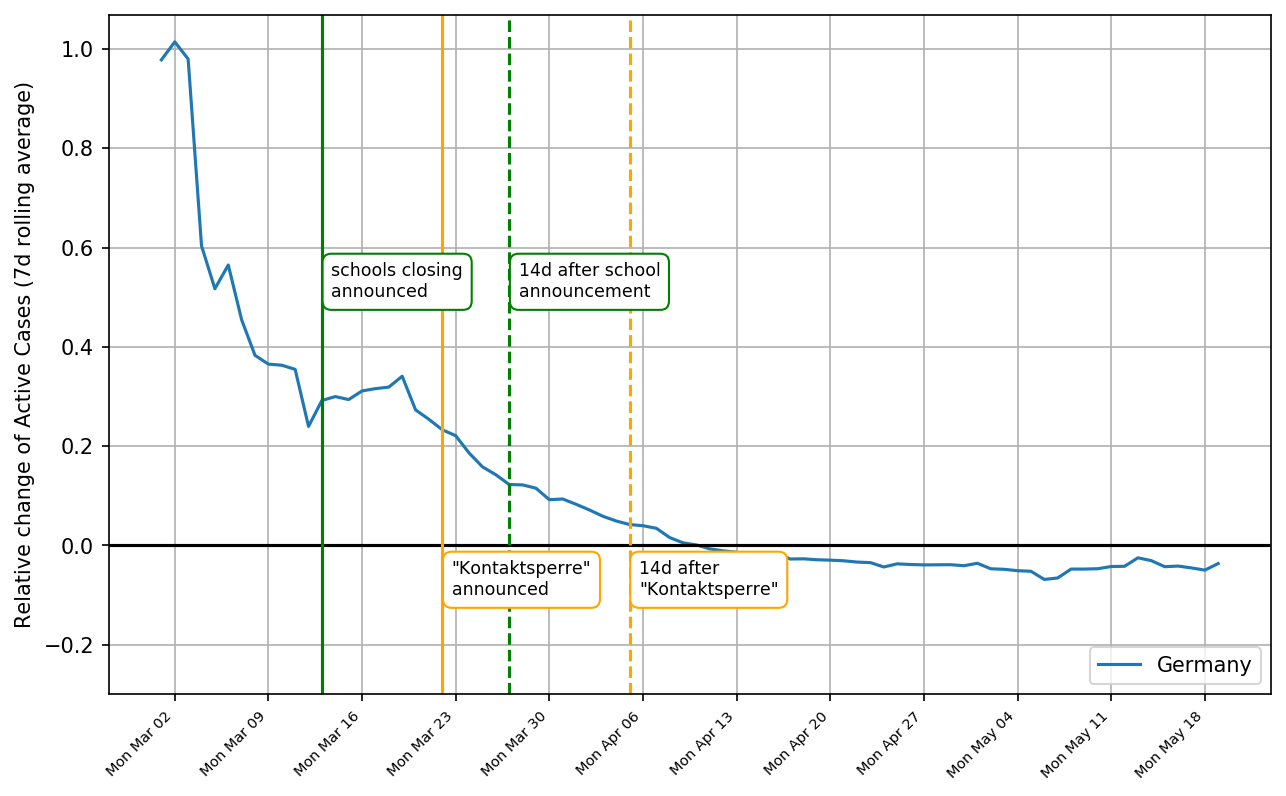

In [164]:
(plot_data, ax) = plot_dates(df=realtive_change_active_country.rolling(7, axis=1).mean(), countries=['Germany'], start_date='3/1/20', what='Relative change of Active Cases (7d rolling average)', ylim_bottom=-0.3, yscale='linear')
plt.axhline(0, color='black')

index=pd.to_datetime('3/13/20')
ax.axvline(x=index, linestyle='solid', color='green')
ax.text(x=index+mdates.num2timedelta(0.7), y=0.5, s='schools closing\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(14), linestyle='dashed', color='green')
ax.text(x=index+mdates.num2timedelta(0.7+14), y=0.5, s='14d after school\nannouncement', fontsize='small', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))

index=pd.to_datetime('3/22/20')
ax.axvline(x=index, linestyle='solid', color='orange')
ax.text(x=index+mdates.num2timedelta(0.7), y=-0.1, s='"Kontaktsperre"\nannounced', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))
ax.axvline(x=index+mdates.num2timedelta(14), linestyle='dashed', color='orange')
ax.text(x=index+mdates.num2timedelta(0.7+14), y=-0.1, s='14d after\n"Kontaktsperre"', fontsize='small', bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.5'))

plt.show()

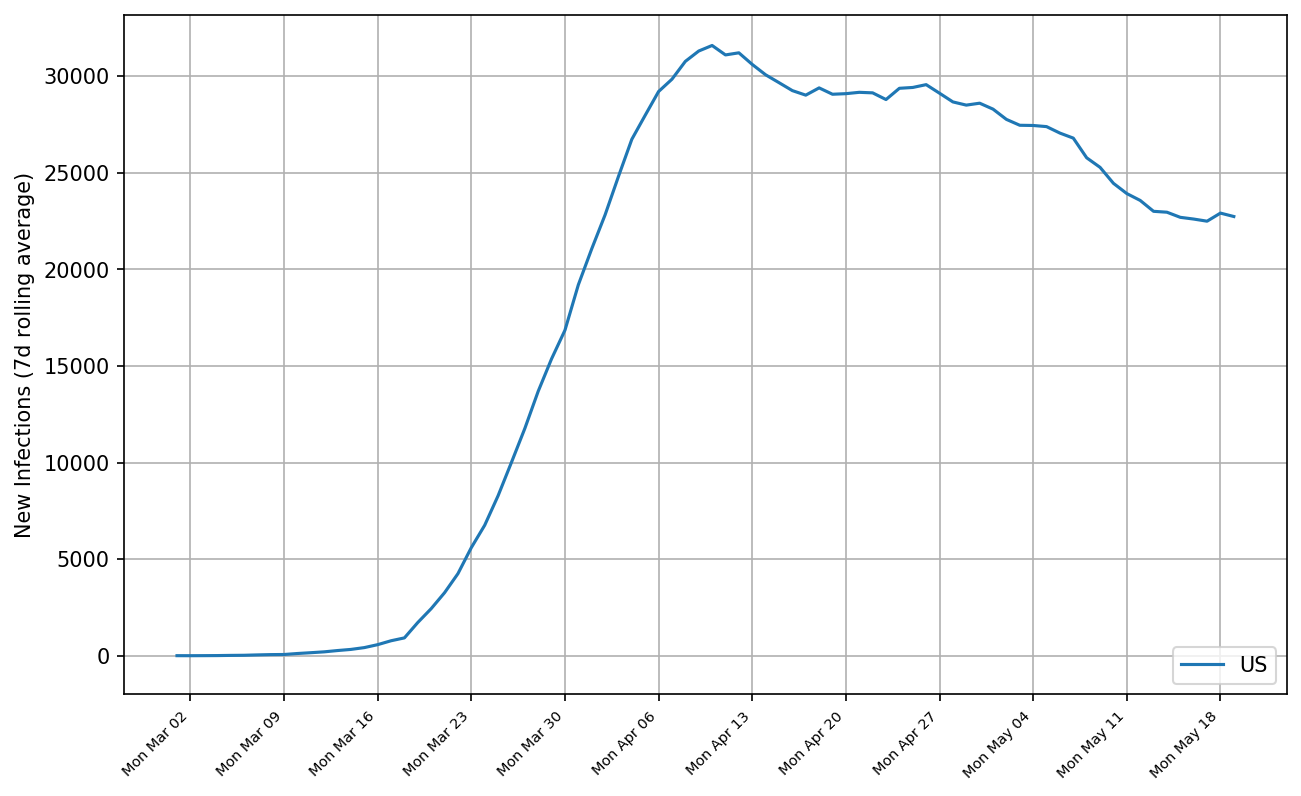

In [165]:
(plot_data, ax) = plot_dates(df=infections_country.rolling(7, axis=1).mean(), countries=['US'], start_date='3/1/20', what='New Infections (7d rolling average)', ylim_bottom=-2000, yscale='linear')


In [166]:
infections_country.rolling(7, axis=1).mean().loc['Germany'].tail(20)

4/30/20    1411.428571
5/1/20     1296.857143
5/2/20     1207.714286
5/3/20     1127.714286
5/4/20     1056.285714
5/5/20     1013.571429
5/6/20      946.142857
5/7/20      917.285714
5/8/20      930.142857
5/9/20      908.142857
5/10/20     887.857143
5/11/20     917.714286
5/12/20     880.571429
5/13/20     848.000000
5/14/20     721.142857
5/15/20     663.571429
5/16/20     632.571429
5/17/20     641.428571
5/18/20     567.857143
5/19/20     658.142857
Name: Germany, dtype: float64